### Usefule resources

https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry-version.html

In [1]:
import os
import joblib
import sklearn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import tarfile
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.model import Model
from sagemaker.image_uris import retrieve

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


### Settings

In [7]:
model_path = "s3://sagemaker-bucket-ds/iris_v2/model/iris-v2-xgboost-2024-06-20-12-51-32/output/model.tar.gz"
model_name = "iris-v2-xgboost-2024-06-20-12-51-32"
model_img = "685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest"

model_package_group_name = 'Iris-v2' # This is an equivalent of a project in model register.
model_package_group_description = 'This is Iris v2 project' # This is description of a package group
model_package_description = "This is first prodction version" # Description of the version of the model

### Clients

In [8]:
s3 = boto3.client('s3')
sagemaker_client = boto3.client('sagemaker')
session = sagemaker.Session()
role = get_execution_role()

### Create model package group

In [9]:
try: # we need to do try/except because if we try to create model package group, when it is already in place, then an error will be raised
    # Create the model package group
    sagemaker_client.create_model_package_group(
        ModelPackageGroupName=model_package_group_name,
        ModelPackageGroupDescription=model_package_group_description
    )
    print(f"Model package group '{model_package_group_name}' created successfully.")
except Exception as e:
    print(f"An error occurred: {e}")

An error occurred: An error occurred (ValidationException) when calling the CreateModelPackageGroup operation: Model Package Group already exists: arn:aws:sagemaker:eu-west-1:211125740051:model-package-group/iris-v2


The model package group Iris-v2 has been created 
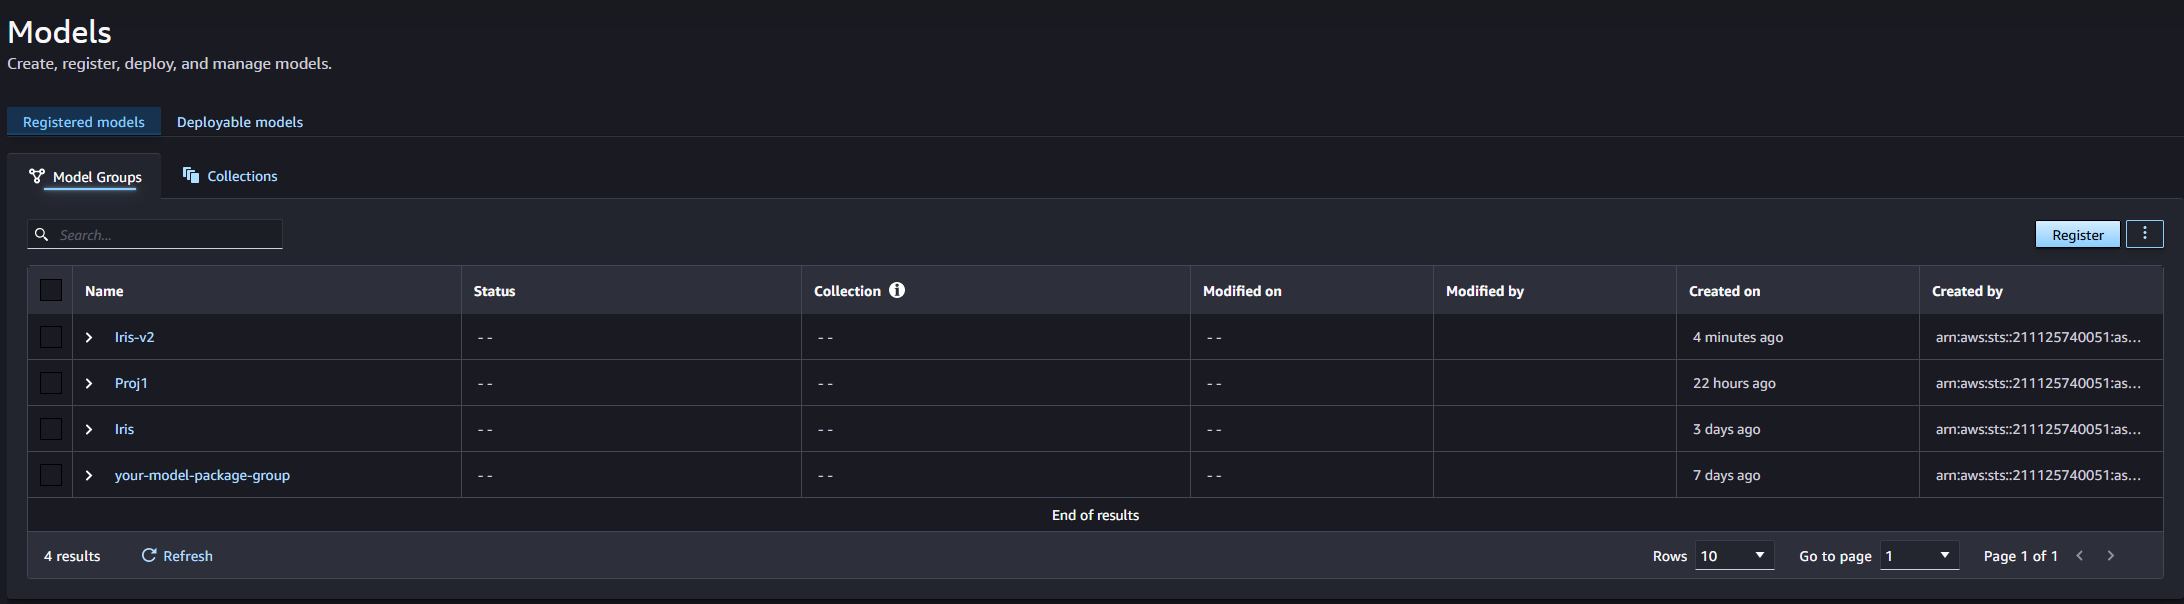

#### Register model

In [15]:
modelpackage_inference_specification = {
    "Containers": [
        {
            "Image": model_img,
            "ModelDataUrl": model_path
        }
    ],
    "SupportedContentTypes": ["text/csv"],
    "SupportedResponseMIMETypes": ["text/csv"]
}

response = sagemaker_client.create_model_package(
    ModelPackageGroupName=model_package_group_name,
    ModelPackageDescription=model_package_description,
    InferenceSpecification=modelpackage_inference_specification
)

print(response)

{'ModelPackageArn': 'arn:aws:sagemaker:eu-west-1:211125740051:model-package/Iris-v2/1', 'ResponseMetadata': {'RequestId': '89febb87-ceee-44d7-be68-ebdc8da5a1ce', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '89febb87-ceee-44d7-be68-ebdc8da5a1ce', 'content-type': 'application/x-amz-json-1.1', 'content-length': '86', 'date': 'Thu, 20 Jun 2024 13:58:00 GMT'}, 'RetryAttempts': 0}}


The first version of the model has been registered
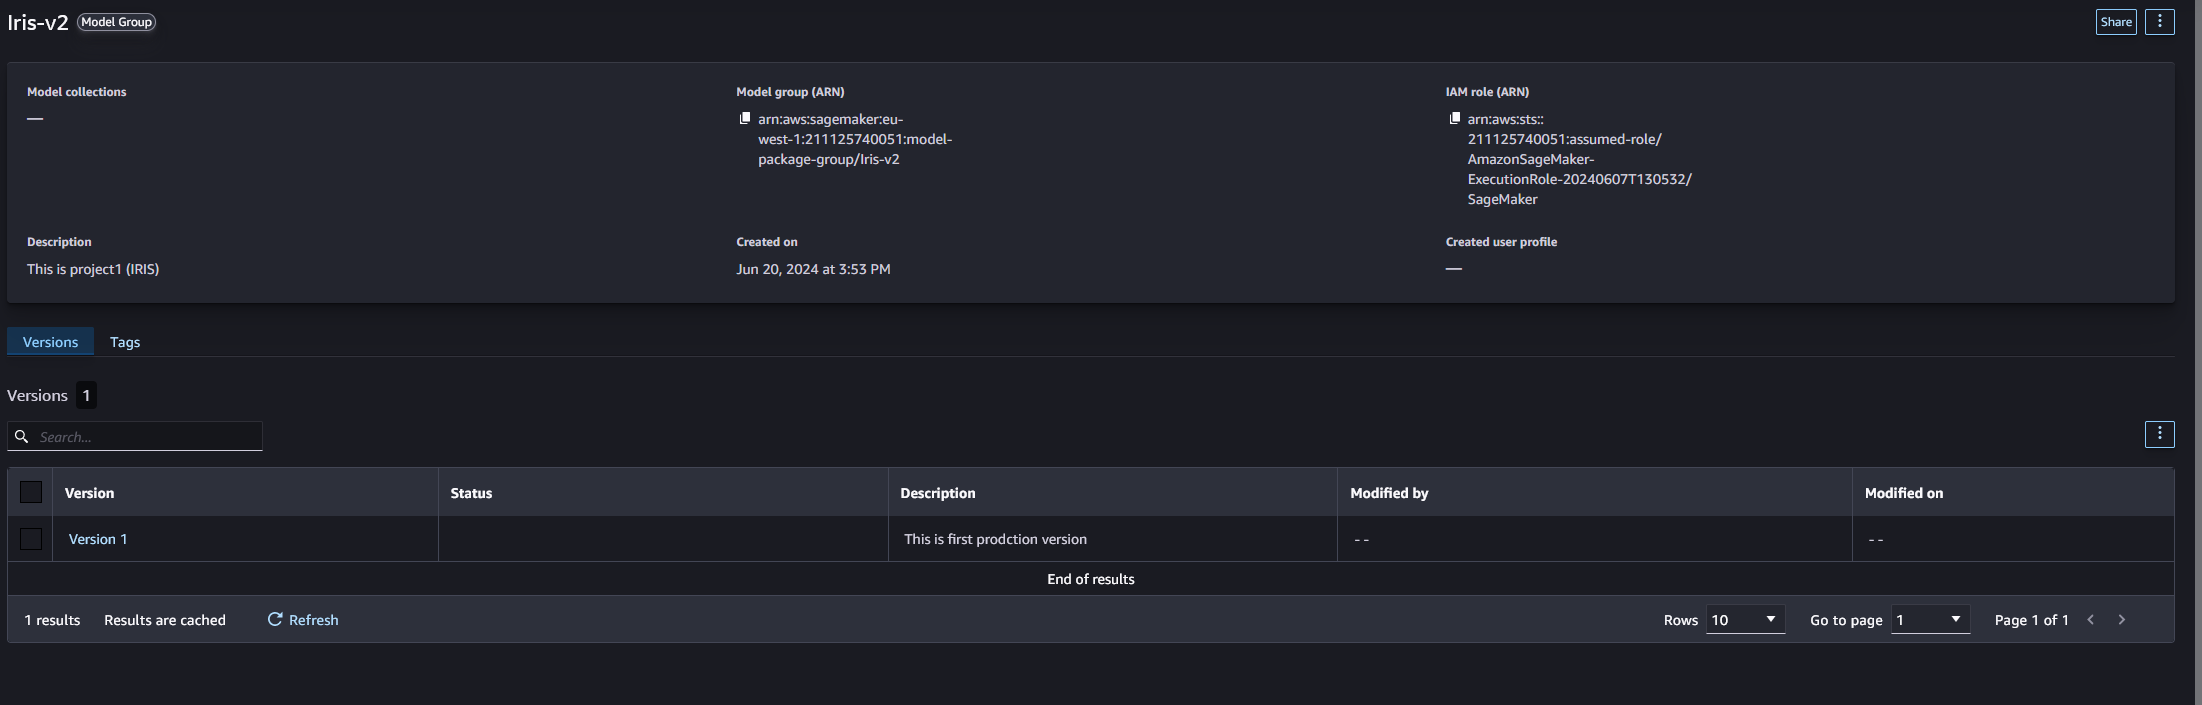

#### List all versions of the model

In [16]:
response = sagemaker_client.list_model_packages(
    ModelPackageGroupName=model_package_group_name
)

model_packages = response['ModelPackageSummaryList']

for model_package in model_packages:
    print(f"Model Package Version: {model_package['ModelPackageVersion']}")
    print(f"Model Package ARN: {model_package['ModelPackageArn']}")
    print(f"Creation Time: {model_package['CreationTime']}")
    print(f"Model Package Status: {model_package['ModelPackageStatus']}")
    print("----------")

Model Package Version: 1
Model Package ARN: arn:aws:sagemaker:eu-west-1:211125740051:model-package/Iris-v2/1
Creation Time: 2024-06-20 13:58:01.264000+00:00
Model Package Status: Completed
----------


#### Get the latest model

In [18]:
latest_model_package = model_packages[-1]

#### Create the model

In [37]:
model_name = 'Iris-v2-Version-1' # Unique name of the model

primary_container = {
    'ModelPackageName': latest_model_package['ModelPackageArn']
}

create_model_response = sagemaker_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer=primary_container
)

print(f"Model ARN: {create_model_response['ModelArn']}")

Model ARN: arn:aws:sagemaker:eu-west-1:211125740051:model/Iris-v2-Version-1


The model can be found in SageMaker -> Inference -> Models
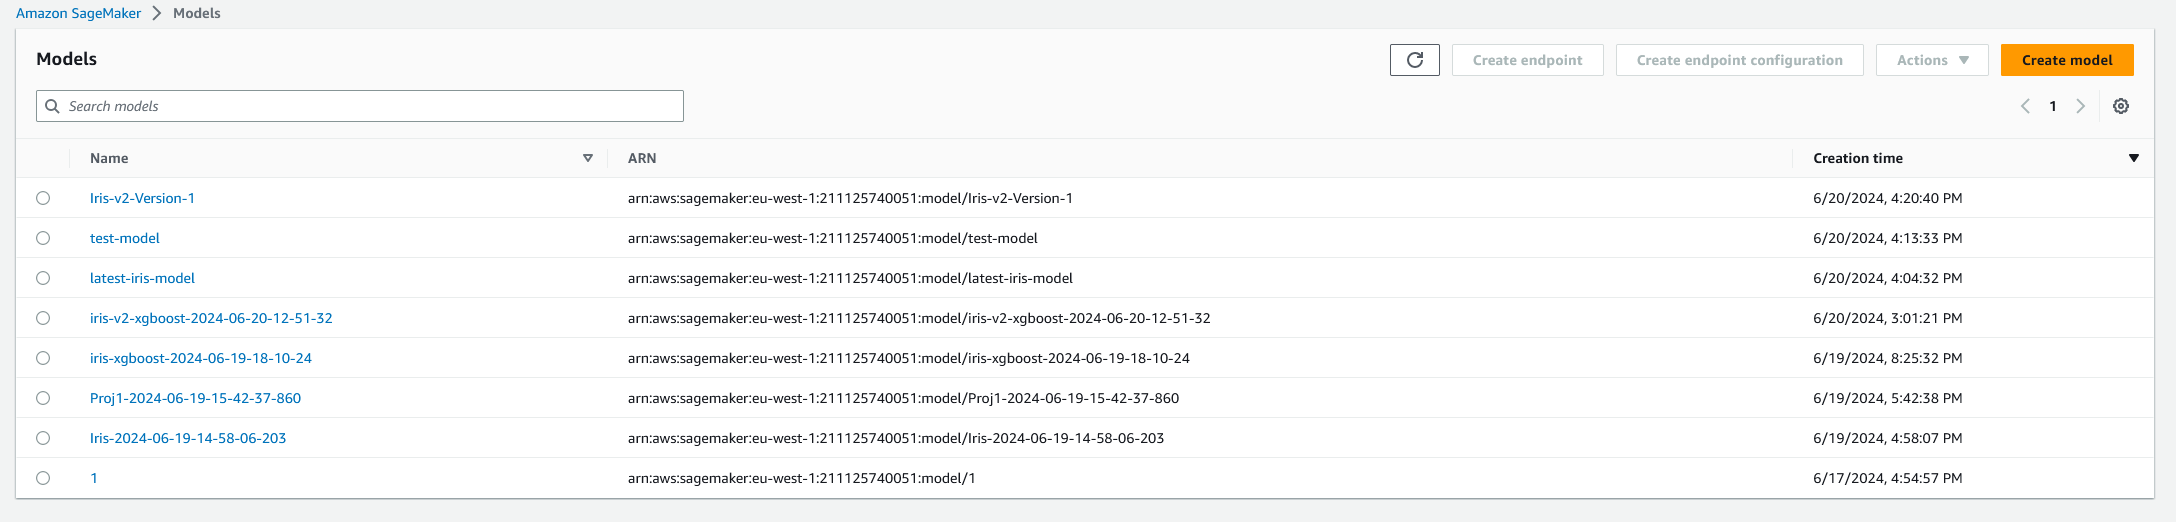

Once the model is created it can be easily used for inference